# 3. Test model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

Load models

In [2]:
from gensim.models import Word2Vec
from api import GenderBiasScorer, percentage_bias, biased_words, EnsembleGenderBiasScorer

In [3]:
model_names = ["wikibios_merged", "bug", "bug_stereotype", "doughman", "doughman_stereotype"]
wvs = [Word2Vec.load(f"models/dataset_{i}.pt").wv for i in tqdm(model_names)]

100%|███████████████████████████████████████████████| 5/5 [00:01<00:00,  4.04it/s]


In [4]:
import gensim.downloader as api
wv_pretrained = api.load('word2vec-google-news-300')
#wv_pretrained = api.load('glove-wiki-gigaword-100')

In [5]:
model_names.append("word2vec-google-news-300")
wvs.append(wv_pretrained)

Testing on lexicons to find best embedding models (requires making full lexicons). I.e. get accuracy using test lexicon on all embedding models + pretrained + tune threshs for each one

In [6]:
from sklearn.metrics import accuracy_score
def lexicon_accuracy(lexicon, scorer, thresh=0.1, verbose=False):
    lexicon = pd.read_csv(f"data/lexicons/{lexicon}_lexicon.csv")
    lexicon["score"] = [scorer.score_token_binary(lexicon.iloc[i,0], thresh=thresh) for i in range(len(lexicon))]
    #accuracy = np.mean(lexicon["label"]==lexicon["score"])
    if verbose:
        print(lexicon[["word","label","score"]].to_string())
    return accuracy_score(lexicon["label"], lexicon["score"])

In [7]:
threshs = np.arange(0, 0.5, 0.02)

In [8]:
def evaluate_and_visualise_models(wvs, model_names, threshs=threshs):
    threshs_optimal = np.zeros(len(wvs))
    test_accuracies = np.zeros(len(wvs))
    bias_accuracies = np.zeros(len(wvs))
    n_absent_words  = np.zeros(len(wvs))
    for i,wv in enumerate(wvs):
        scorer = GenderBiasScorer(wv)
        accuracies = np.zeros(len(threshs))

        for j,thresh in enumerate(threshs):
            accuracies[j] = lexicon_accuracy("test", scorer, thresh=thresh)

        threshs_optimal[i] = threshs[accuracies.argmax()]
        test_accuracies[i] = accuracies[accuracies.argmax()]
        bias_accuracies[i] = lexicon_accuracy("bias", scorer, thresh=threshs_optimal[i])

        bias_lexicon = pd.read_csv(f"data/lexicons/bias_lexicon.csv")
        for k in range(len(bias_lexicon)):
            try:
                _ = wv[bias_lexicon.iloc[k,0]]
            except KeyError:
                n_absent_words[i] += 1

    results = pd.DataFrame({"model_names": model_names, "n_absent_words": n_absent_words, 
                            "threshs_optimal": threshs_optimal, "test_accuracies": test_accuracies, 
                            "bias_accuracies": bias_accuracies})
    return results

In [9]:
results = evaluate_and_visualise_models(wvs, model_names, threshs)

Tokens co-operative not found in model vocabulary
Tokens yielding not found in model vocabulary
Tokens punctual not found in model vocabulary
Tokens tenaciousness not found in model vocabulary
Tokens reassurance not found in model vocabulary
Tokens fatherly not found in model vocabulary
Tokens motherly not found in model vocabulary
Tokens gal not found in model vocabulary
Tokens fatherly not found in model vocabulary
Tokens motherly not found in model vocabulary
Tokens gal not found in model vocabulary
Tokens fatherly not found in model vocabulary
Tokens motherly not found in model vocabulary
Tokens gal not found in model vocabulary
Tokens fatherly not found in model vocabulary
Tokens motherly not found in model vocabulary
Tokens gal not found in model vocabulary
Tokens fatherly not found in model vocabulary
Tokens motherly not found in model vocabulary
Tokens gal not found in model vocabulary
Tokens fatherly not found in model vocabulary
Tokens motherly not found in model vocabulary
T

<AxesSubplot:xlabel='model_names', ylabel='bias_accuracies'>

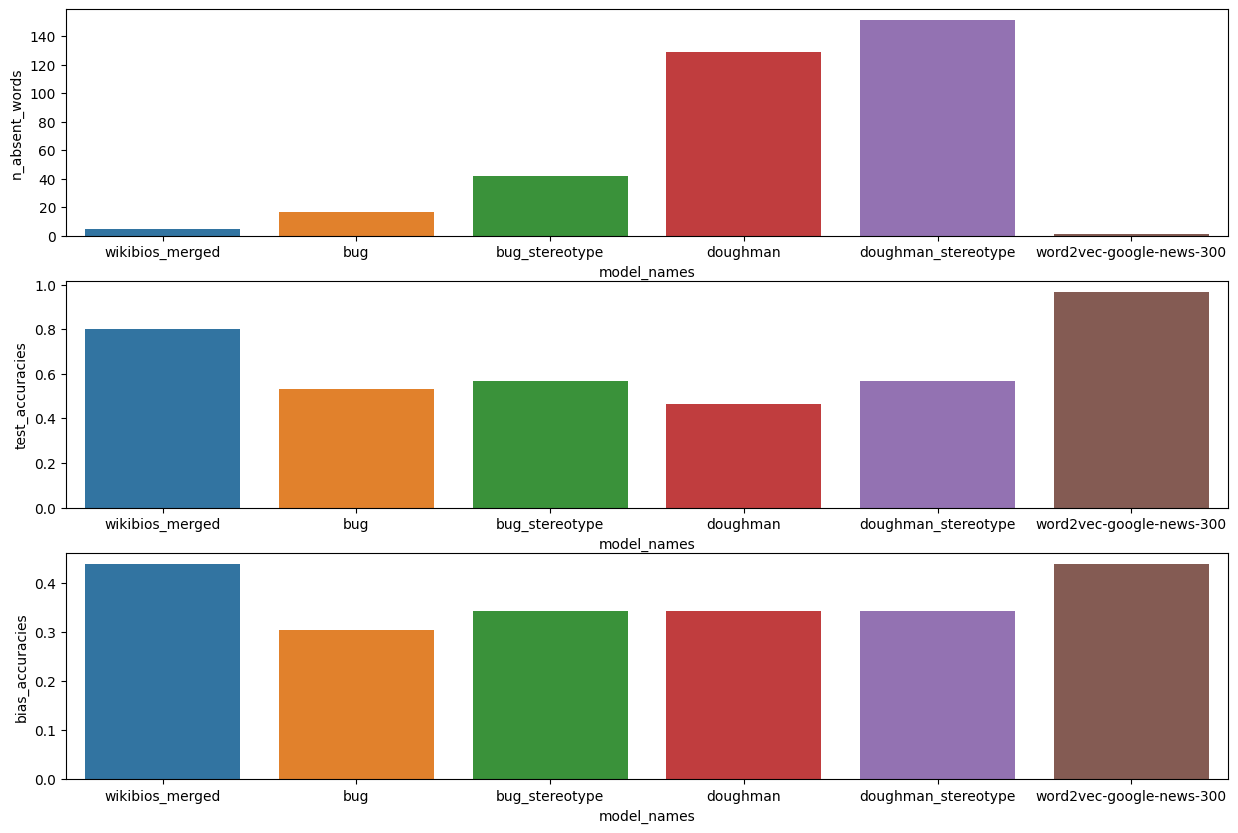

In [10]:
plt.figure(figsize=(15, 10))
plt.subplot(3,1,1)
sns.barplot(results, x="model_names", y="n_absent_words")
plt.subplot(3,1,2)
sns.barplot(results, x="model_names", y="test_accuracies")
plt.subplot(3,1,3)
sns.barplot(results, x="model_names", y="bias_accuracies")

Create ensemble model out of all model.wvs 

In [11]:
ensemble_scorer = EnsembleGenderBiasScorer(wvs=[Word2Vec.load(f"models/dataset_{i}.pt").wv for i in ["wikibios_merged", "bug"]] + [wv_pretrained],
                                       threshs=results[results["model_names"].isin(("wikibios_merged", "bug", "word2vec-google-news-300"))]["threshs_optimal"].to_numpy())

Compare original models with ensemble model

In [12]:
model_names = ["wikibios_merged", "bug", "word2vec-google-news-300"]
wvs = [Word2Vec.load(f"models/dataset_{i}.pt").wv for i in ["wikibios_merged", "bug"]] + [wv_pretrained]
results = evaluate_and_visualise_models(wvs, model_names, threshs)

Tokens co-operative not found in model vocabulary
Tokens yielding not found in model vocabulary
Tokens punctual not found in model vocabulary
Tokens tenaciousness not found in model vocabulary
Tokens reassurance not found in model vocabulary
Tokens fatherly not found in model vocabulary
Tokens motherly not found in model vocabulary
Tokens gal not found in model vocabulary
Tokens fatherly not found in model vocabulary
Tokens motherly not found in model vocabulary
Tokens gal not found in model vocabulary
Tokens fatherly not found in model vocabulary
Tokens motherly not found in model vocabulary
Tokens gal not found in model vocabulary
Tokens fatherly not found in model vocabulary
Tokens motherly not found in model vocabulary
Tokens gal not found in model vocabulary
Tokens fatherly not found in model vocabulary
Tokens motherly not found in model vocabulary
Tokens gal not found in model vocabulary
Tokens fatherly not found in model vocabulary
Tokens motherly not found in model vocabulary
T

In [13]:
results = results.append({"model_names": "ensemble", "n_absent_words": 0, "threshs_optimal": 0,
                                            "test_accuracies": lexicon_accuracy("test", ensemble_scorer), 
                                            "bias_accuracies": lexicon_accuracy("bias", ensemble_scorer)}, ignore_index=True)

[1, 1, 1] 1
[1, 1, 1] 1
[1, 1, 1] 1
[0, -1, 1] 0
Tokens fatherly not found in model vocabulary
[-1, 0, 1] 0
[1, 1, 1] 1
[0, -1, 1] 0
[1, 1, 1] 1
[1, 1, 1] 1
[1, 1, 1] 1
[-1, -1, -1] -1
[-1, -1, -1] -1
[-1, -1, -1] -1
Tokens motherly not found in model vocabulary
[-1, 0, -1] -1
[-1, -1, -1] -1
[-1, -1, -1] -1
[-1, -1, -1] -1
[-1, -1, -1] -1
[-1, 1, -1] -1
Tokens gal not found in model vocabulary
[-1, 0, -1] -1
[1, 1, 0] 1
[0, 1, 0] 0
[0, -1, 0] 0
[1, 0, 0] 0
[0, 1, -1] 0
[1, 1, 0] 1
[0, 1, 0] 0
[0, 1, 0] 0
[0, 1, 0] 0
[0, 0, 0] 0
[0, -1, 0] 0
[-1, 0, 0] 0
[1, 0, 0] 0
[0, -1, 0] 0
[-1, -1, 0] -1
[0, -1, 0] 0
[1, -1, 0] 0
[-1, -1, 0] -1
[1, 1, 1] 1
[1, -1, 1] 1
[0, -1, 1] 0
[1, -1, 0] 0
[1, -1, 0] 0
[0, -1, 1] 0
[1, -1, 0] 0
[0, 0, 1] 0
[0, 1, 1] 1
[0, -1, 1] 0
[0, 1, 1] 1
[0, 0, 0] 0
[0, -1, 0] 0
[0, 0, 1] 0
[0, -1, 1] 0
[0, -1, 0] 0
[1, 1, 0] 1
[1, 1, 0] 1
[1, -1, 1] 1
Tokens headstrong not found in model vocabulary
[-1, 0, 0] 0
[0, -1, 1] 0
[0, 0, 1] 0
[1, 0, 0] 0
[0, -1, -1] -1
[0, 0,

/var/folders/yx/g0jn6h0559x_dvjfg342fl240000gn/T/ipykernel_29022/2779782670.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"model_names": "ensemble", "n_absent_words": 0, "threshs_optimal": 0,


<AxesSubplot:xlabel='model_names', ylabel='bias_accuracies'>

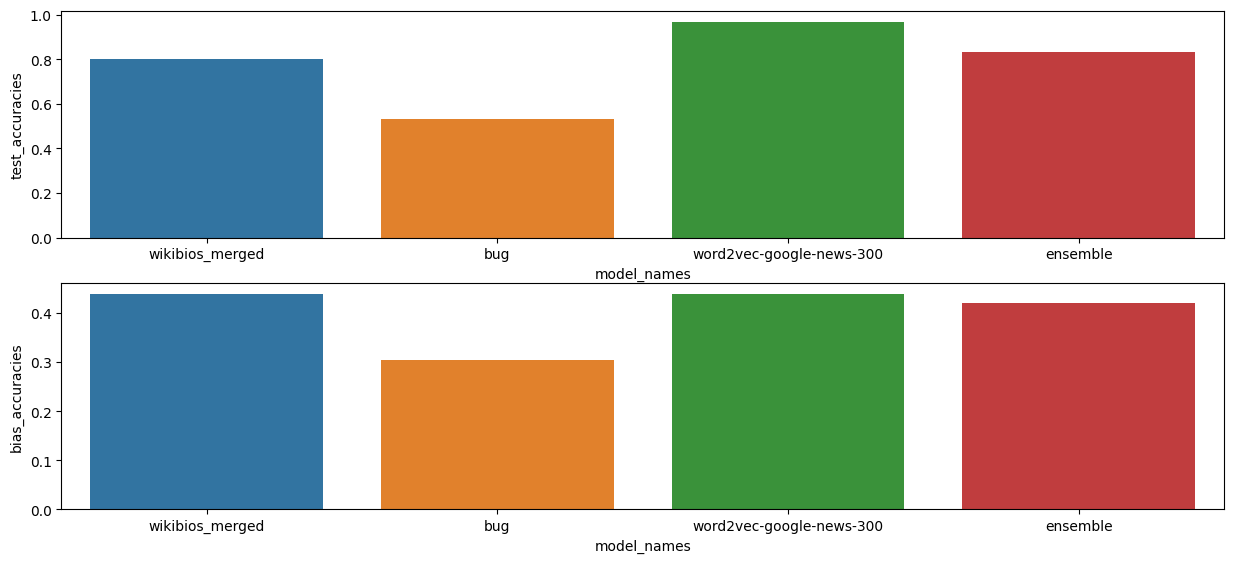

In [14]:
plt.figure(figsize=(15, 10))
plt.subplot(3,1,1)
sns.barplot(results, x="model_names", y="test_accuracies")
plt.subplot(3,1,2)
sns.barplot(results, x="model_names", y="bias_accuracies")

In [15]:
lexicon_accuracy("bias", ensemble_scorer, verbose=True)

[0, -1, 0] 0
[-1, 0, 0] 0
[1, 0, 0] 0
[0, -1, 0] 0
[-1, -1, 0] -1
[0, -1, 0] 0
[1, -1, 0] 0
[-1, -1, 0] -1
[1, 1, 1] 1
[1, -1, 1] 1
[0, -1, 1] 0
[1, -1, 0] 0
[1, -1, 0] 0
[0, -1, 1] 0
[1, -1, 0] 0
[0, 0, 1] 0
[0, 1, 1] 1
[0, -1, 1] 0
[0, 1, 1] 1
[0, 0, 0] 0
[0, -1, 0] 0
[0, 0, 1] 0
[0, -1, 1] 0
[0, -1, 0] 0
[1, 1, 0] 1
[1, 1, 0] 1
[1, -1, 1] 1
Tokens headstrong not found in model vocabulary
[-1, 0, 0] 0
[0, -1, 1] 0
[0, 0, 1] 0
[1, 0, 0] 0
[0, -1, -1] -1
[0, 0, 0] 0
Tokens individualistic not found in model vocabulary
[-1, 0, 0] 0
[-1, -1, 0] -1
[0, -1, 0] 0
[0, -1, 0] 0
[0, -1, 0] 0
[0, -1, 1] 0
[-1, -1, -1] -1
[0, 0, 0] 0
[0, -1, 1] 0
[1, 0, 1] 1
[1, -1, 1] 1
[0, -1, 0] 0
[0, 0, 0] 0
[1, -1, 0] 0
[0, 1, 1] 1
[0, 0, 0] 0
[0, -1, 0] 0
[1, 0, 0] 0
[-1, 0, -1] -1
[0, -1, -1] -1
[-1, -1, 0] -1
Tokens cheery not found in model vocabulary
[-1, 0, -1] -1
[0, 0, 0] 0
[-1, -1, 0] -1
[-1, 0, 1] 0
[-1, -1, 0] -1
[-1, -1, 0] -1
[0, 1, 1] 1
[0, 1, 0] 0
[-1, 0, 0] 0
Tokens co-operative not found in

0.41935483870967744

In [126]:
test_document = "My guess is she can afford to pay a nutritionist who limits her to a reasonable caloric intake and a personal trainer who keeps her on a workout plan."

In [127]:
tokens, scores = ensemble_scorer.score_document(test_document)

[0, 0, 0] 0
[-1, 0, -1] -1
[0, 0, 0] 0
[0, 0, 0] 0
[-1, 0, -1] -1
[0, 0, 0] 0
[0, 0, -1] 0
[0, 0, 0] 0
Tokens caloric not found in model vocabulary
[0, 0, 0] 0
[0, 0, 0] 0
[0, 0, 0] 0
[0, 0, 0] 0
[0, 0, -1] 0
[0, 0, 0] 0
[0, 0, 0] 0


In [128]:
percentage_bias(test_document, scores)

0.08

In [129]:
biased_words(tokens, scores)

{'biased_m': [],
 'biased_f': ['she', 'nutritionist'],
 'unbiased': ['guess',
  'afford',
  'pay',
  'limit',
  'her',
  'reasonable',
  'caloric',
  'intake',
  'personal',
  'trainer',
  'her',
  'workout',
  'plan']}

Wordcloud vis

In [130]:
with open("data/corpus/dataset_doughman.txt", "r") as f:
    document = " ".join(f.read().splitlines())

In [87]:
ensemble_scorer.threshs = [0.26, 0.16, 0.08]

In [131]:
#prefer these
ensemble_scorer.threshs = [0.4, 0.8, 0.13]

In [132]:
scorer = ensemble_scorer
#scorer = GenderBiasScorer(wvs[2])
tokens, scores = scorer.score_document(document, thresh=0.13)

[0, 0, 0] 0
[0, 0, 0] 0
Tokens rhymist not found in model vocabulary
Tokens rhymist not found in model vocabulary
Tokens rhymist not found in model vocabulary
[0, 0, 0] 0
[0, 0, 1] 0
[0, 0, 0] 0
[0, 0, 0] 0
[0, 0, 0] 0
[0, 0, 0] 0
[0, 0, 1] 0
[0, 0, 0] 0
[0, 0, 0] 0
[0, 0, 0] 0
[0, 0, 0] 0
[0, 0, 0] 0
[0, 0, 0] 0
[0, 0, 0] 0
[0, 0, 1] 0
[0, 0, 0] 0
[0, 0, 0] 0
[0, 0, 0] 0
[0, 0, 1] 0
[0, 0, 0] 0
[0, 0, 0] 0
[0, 0, 0] 0
Tokens indigestion not found in model vocabulary
Tokens indigestion not found in model vocabulary
[0, 0, 0] 0
[0, 0, 0] 0
[0, 0, 0] 0
[0, 0, 0] 0
Tokens eczema not found in model vocabulary
Tokens eczema not found in model vocabulary
[0, 0, 0] 0
Tokens rheumatism not found in model vocabulary
[0, 0, 0] 0
[0, 0, 0] 0
[0, 0, 0] 0
[0, 0, 0] 0
[0, 0, 1] 0
[0, 0, 0] 0
[0, 0, 0] 0
[1, 0, 1] 1
[0, 0, 1] 0
[0, 0, 0] 0
[0, 0, 0] 0
[0, 0, 0] 0
[0, 0, 0] 0
[0, 0, 0] 0
[0, 0, 0] 0
[0, 0, 1] 0
[0, 0, 0] 0
[0, 0, 1] 0
[0, 0, 0] 0
[0, 0, 0] 0
[0, 0, 0] 0
[0, 0, 0] 0
[0, 0, 0] 0
[0, 0, 

In [133]:
percentage_bias(document, scores)

0.010056640850768697

In [134]:
words = biased_words(tokens, scores)
print("m", set(words["biased_m"]))
print("f", set(words["biased_f"]))

m {'dude', 'man', 'men', 'heckle', 'ball', 'himself', 'guy', 'team', 'game', 'captain', 'club'}
f {'psychotherapist', 'she', 'sylvia', 'sophie', 'female', 'niece', 'hygienist', 'paralegal', 'cardi', 'lisa', 'teresa', 'homemaker', 'sister', 'kaur', 'nutritionist', 'national', 'caregiver', 'wendy', 'boyfriend', 'woman'}


In [135]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

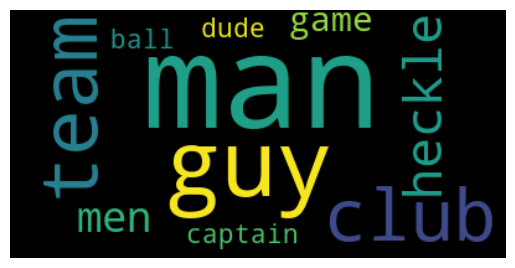

In [136]:
wordcloud = WordCloud().generate(" ".join(words["biased_m"]))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

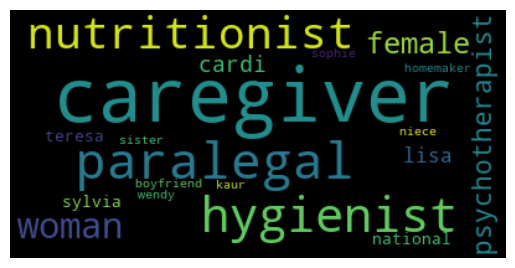

In [137]:
wordcloud = WordCloud().generate(" ".join(words["biased_f"]))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [139]:
with open("kainosspecs.txt", "r") as f:
    document = " ".join(f.read().splitlines())

In [140]:
scorer = ensemble_scorer
tokens, scores = scorer.score_document(document)
words = biased_words(tokens, scores)
print("m", set(words["biased_m"]))
print("f", set(words["biased_f"]))

[0, 0, 0] 0
[0, 0, 0] 0
[0, 0, 0] 0
[0, 0, 0] 0
[0, 0, 0] 0
[0, 0, 0] 0
[0, 0, 0] 0
[0, 0, 0] 0
[0, 0, 0] 0
Tokens kainos not found in model vocabulary
Tokens kainos not found in model vocabulary
Tokens kainos not found in model vocabulary
[0, 0, 0] 0
[0, 0, 0] 0
[0, 0, 0] 0
[0, 0, 0] 0
[0, 0, 0] 0
[0, 0, 0] 0
[0, 0, 0] 0
[0, 0, 0] 0
[0, 0, 0] 0
[0, 0, 0] 0
[0, 0, 0] 0
[0, 0, 0] 0
[0, 0, 0] 0
[0, 0, 0] 0
[0, 0, 0] 0
[0, 0, 0] 0
[0, 0, 0] 0
[0, 0, 0] 0
[0, 0, 0] 0
[0, 0, 0] 0
[0, 0, 0] 0
[0, 0, 0] 0
[0, 0, 0] 0
[1, 0, 1] 1
[0, 0, 0] 0
[0, 0, 0] 0
[0, 0, 0] 0
[0, 0, 0] 0
[0, 0, 0] 0
[0, 0, 0] 0
[0, 0, 0] 0
[0, 0, 0] 0
[0, 0, 0] 0
[1, 0, 1] 1
[0, 0, 0] 0
[0, 0, 0] 0
[1, 0, 1] 1
[0, 0, 1] 0
[0, 0, 0] 0
[0, 0, 0] 0
[0, 0, 0] 0
[0, 0, 0] 0
Tokens stakeholder not found in model vocabulary
[0, 0, 0] 0
[0, 0, 0] 0
[0, 0, 0] 0
[0, 0, 0] 0
[0, 0, 0] 0
[0, 0, 0] 0
[0, 0, 0] 0
[0, 0, 0] 0
[0, 0, 0] 0
[0, 0, 0] 0
[0, 0, 1] 0
[0, 0, 0] 0
[0, 0, 0] 0
[0, 0, 0] 0
[0, 0, 0] 0
[0, 0, 0] 0
[0, 0, 0] 0
[0,